**EM Algorithm** (Expectation - Maximization)

We're going to implement the EM algorithm for a mixture of Bernoullis

The Expectation-Maximization algo. is used in sk-learn, for instance in GMMs: http://scikit-learn.org/stable/modules/mixture.html#estimation-algorithm-expectation-maximization

Additional notes are available here: https://allauzen.github.io/articles/MixturesAndEM/


## Think for a bit

Is EM a supervised or unsupervised learning algorithm ? 

What kind of data set is MNIST ? 

Then, what are we going to do ?  How is this called ?



## Implement the EM algo. for a mixture of Bernoulli (laws)
- The cluster number K should be an argument of the function
- A maximum number of iterations, *MaxIt*, should act as stopping condition
- During the E step, compute and *store* the log-likelihood of the data, so as to monitor its evolution along iterations (~epochs)

Apply the algorithm on MNIST:
- try out K=5,10,15
- Visualize the images coresponding to each cluster's paraemeters. Would that be as straightforward in a Gaussian model (visualizing all the model's parameters?)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

In [5]:
## we load the whole data set at once, so as to manipulate it directly (using numpy arrays)
## for very large data sets, one needs to read on-the-fly (at least at production time, not at the debugging stage)

## Load the dataset -- (python2)
#import cPickle, gzip
#with gzip.open('./mnist.pkl.gz','rb') as f :
#    train_set, valid_set, test_set = cPickle.load(f)

# ### Load the dataset -- (python3)
import pickle, gzip
with gzip.open('./mnist.pkl.gz','rb') as f :
     u = pickle._Unpickler( f )
     u.encoding = 'latin1'
     train_set, valid_set, test_set = u.load()

## split train an dtest data, to avoid inadvertently cheating.
unlabelled_dataset = train_set[0].copy()
labels_for_final_accuracy_measurement = train_set[1].copy()
del train_set

## these would be useful, for now we don't use them
del valid_set  
del test_set

In [6]:
unlabelled_dataset

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
unlabelled_dataset.shape

(50000, 784)

In [8]:
## binarize so as to go into Bernoulli-space
threshold = 0.3
for i in range(unlabelled_dataset.shape[0]): 
    unlabelled_dataset[i,:]= 1.0*(unlabelled_dataset[i]>threshold)
## (unlabelled_dataset[i]>threshold) is now an array of Booleans

In [9]:
## inspect the new values "by hand", to check.
unlabelled_dataset[0][300:400] ## reading 
## we do NOT convert to Integers, instead we stay in floats. Because we'll compute averages later (thus, divide..)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [10]:
## for debugging, we may want to use a small piece of the sample
## data size will be divided by a factor "subSampling"
subSampling = 1
# subSampling = 10  # use more data for more accuracte results !
## in the end, we may use all of it (set this to 1) 

In [11]:
## sort data to make sure all classes are equally present ##
ordre = np.argsort(labels_for_final_accuracy_measurement)
unlabelled_dataset = unlabelled_dataset[ordre]
labels_for_final_accuracy_measurement = labels_for_final_accuracy_measurement[ordre]

## do the sub-sampling
dataset = unlabelled_dataset[::subSampling].copy()
subSampledLabels = labels_for_final_accuracy_measurement[::subSampling].copy()

In [12]:
## check it:
subSampledLabels[:10000]

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [13]:
## compute the proba of an image xi, 
## given its cluster k and parameters theta 
def compute_P_Xi_given_k_and_theta(xi, k, theta):
    EPS = 1e-15
    ### loop version: ~100x slower
    # dim = (xi.shape)[0]
    # output = 0.0
    # for j in range(dim):
    #     output += xi[j]*np.log(theta[k,j]+EPS) + (1.0-xi[j])*np.log(1-theta[k,j]+EPS)
    ### numpy version: much much faster ! 
    output = np.dot(xi, np.log(theta[k]+EPS)) +  np.dot( 1.0-xi, np.log(1-theta[k]+EPS) )
    return np.exp(output)
# outputForDebug = compute_P_Xi_given_k_and_theta(xi, k, theta)

In [14]:
## python-note: at debug time, don't write a function, instead, write directly in the main
## when evreything works well, encapsulate the piece of code into a function for later re-use (and lisibility)
K=10
MaxIt=5

#def AlgoEM(dataset, K, MaxIt, subSampledLabels):
## we set the seed to a constant so as to have repeatable experiences 
## (at debug time, and when comparing hyper-parameters)
np.random.seed(42)

## we'll assume dataset[i,j] is the value of pixel j of image i.
Nex = (dataset.shape)[0] ## number of examples (= number of images)
dim = (dataset.shape)[1] ## dimension of parameters space (=number of pixels per image, in the Bernoulli case)

## initialization ##
## here we do: random affectations (not advised)
## (in that case, we perform the M step first, then E step)
affectations = np.random.random((K, Nex)) ## denoted a_{k,i}
affectations /= np.sum(affectations, axis=0)
classFrequencies = np.zeros(K) ## denoted pi_k 
theta = np.zeros((K, dim))   ## denoted theta_{k,j}
  
## main loop ##
for iteration in range(0,MaxIt,1):
    ######################
    ## step M: update of "pi_k, mu_k" (classFrequencies, theta)  ##
    ## update pi_k:
    for k in range(K):
        classFrequencies[k] = np.sum(affectations[k,:])/Nex
    ## update theta[k,j]:  (using the very efficient numpy matrix product)
    theta = np.matmul(affectations, dataset) ## theta[k,j]  =  sum_i affectations[k,i]*dataset[i,j]
    for k in range(K):
        theta[k,:] /= (Nex*classFrequencies[k])
             
    ######################
    ## step E: update of "a_ik" (affectations) ##
    
    ### semi-numpy version: (much slower)
    # for i in range(Nex):
    #     xi = dataset[i]
    #     for k in range(K):
    #         temporary = compute_P_Xi_given_k_and_theta(xi,k, theta)
    #         affectations[k,i] = classFrequencies[k]*temporary
    #     affectations[:,i] /= np.sum(affectations[:,i]) ## divide by the total (denominator)
    
    ### fully-numpy version : (much faster)
    for k in range(K):
        temporary = compute_P_Xi_given_k_and_theta(dataset,k, theta)
        affectations[k] = classFrequencies[k]*temporary    
    affectations /= np.sum(affectations,axis=0) ## divide by the total (denominator)
    
    ## monitoring of the quality of te clustering ##
    LogLikelihood = np.log(np.max(affectations, axis=0)) 
    print(np.mean(LogLikelihood))
##########################################################################


-2.0225906098908344
-0.30737683947663097
-0.02659633197514644
-0.016816690701068438
-0.01567765905172321


In [36]:
classFrequencies

array([0.07946949, 0.07861571, 0.0933003 , 0.00664163, 0.07973638,
       0.0514591 , 0.08376498, 0.09808613, 0.05890282, 0.09948634,
       0.04276819, 0.06570548, 0.08085626, 0.04078446, 0.04042272])

In [37]:
np.sum(affectations, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

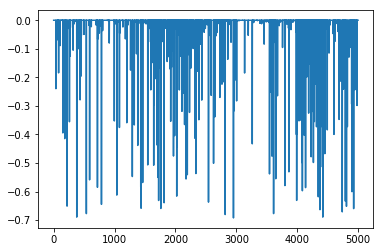

In [40]:
plt.plot(np.log(np.max(affectations, axis=0)) )  #log-likelihood

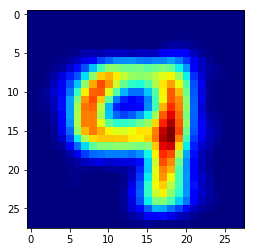

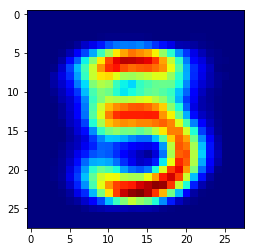

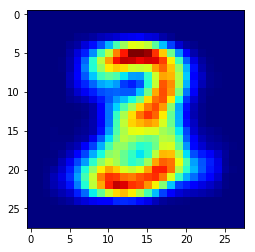

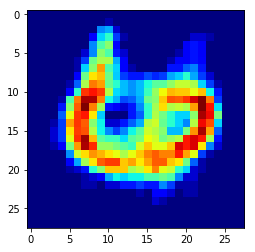

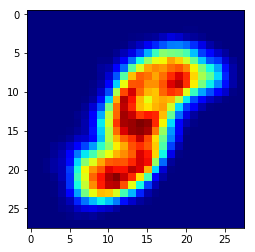

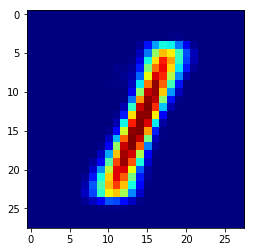

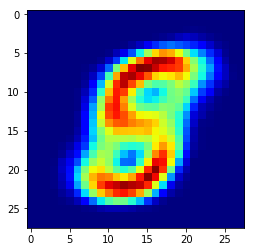

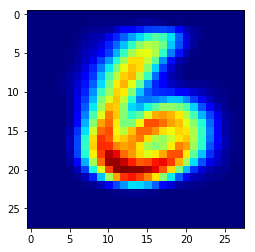

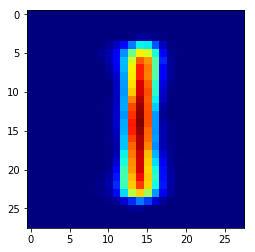

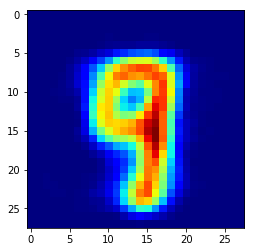

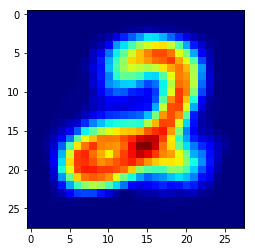

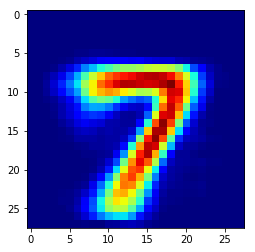

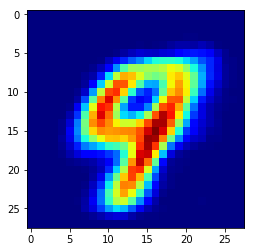

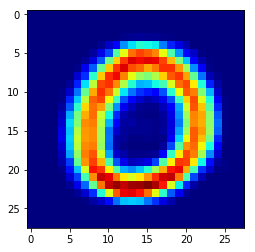

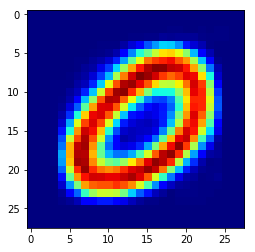

In [41]:
## we can visualize the parameters theta, cluster by cluster
for k in range(K):
    plt.imshow(theta[k].reshape(28,28) , matplotlib.pyplot.cm.jet)
    matplotlib.pyplot.show()

Now, let's monitor something more interpretable than the log-likelihood... what could it be ? 

Trick: you may use the function np.argmax(), and maybe just a couple of labels from a couple of examples

**Question**: would this strategy be possible for a purely unsupervised task ?

## ANSWER: we can get the class corresponding best to each cluster, then compute an error rate !

And no, it is only possible if we have access to at least some of the labels ! (not possible in a truly unsupervised task)

In [74]:
## 1st attempt to assign a class to each cluster ##
## for each cluster (1...K), the most certainly-assigned data point (single image) is the image number:
print(" for each cluster (1...K), the most certainly-assigned data point (single image) is the timage number:", \
      np.argmax(affectations,axis=1))
print("the corresponding labels are:", subSampledLabels[np.argmax(affectations,axis=1)])
print("ok, so this will not work out...")

(' for each cluster (1...K), the most certainly-assigned data point (single image) is the timage number:', array([  132,   757,   539,  5174,    34,  4934,   307,   204,  4932,
        4981,     1,  6509, 20682,     0,  9427]))
('the corresponding labels are:', array([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 4, 0, 1]))
ok, so this will not work out...


In [76]:
## 2nd attempt to assign a class to each cluster ##
predictions = np.argmax(affectations,axis=0)
print("here is an example of what np.bincount does:", subSampledLabels[predictions == 0], np.bincount(subSampledLabels[predictions == 0]))
predictedClass = np.zeros(K, dtype=int)
for k in range(K):
    predictedClass[k] = np.argmax(np.bincount(subSampledLabels[predictions == k]))   
    print("cluster ",k," represents (probably) the class (digit number) : ",predictedClass[k] )


('here is an example of what np.bincount does:', array([0, 0, 0, ..., 9, 9, 9]), array([  23,    4,  107,   49, 1585,   97,   83,  613,   55, 1042]))
('cluster ', 0, ' represents (probably) the class (digit number) : ', 4)
('cluster ', 1, ' represents (probably) the class (digit number) : ', 3)
('cluster ', 2, ' represents (probably) the class (digit number) : ', 3)
('cluster ', 3, ' represents (probably) the class (digit number) : ', 2)
('cluster ', 4, ' represents (probably) the class (digit number) : ', 5)
('cluster ', 5, ' represents (probably) the class (digit number) : ', 1)
('cluster ', 6, ' represents (probably) the class (digit number) : ', 8)
('cluster ', 7, ' represents (probably) the class (digit number) : ', 6)
('cluster ', 8, ' represents (probably) the class (digit number) : ', 1)
('cluster ', 9, ' represents (probably) the class (digit number) : ', 9)
('cluster ', 10, ' represents (probably) the class (digit number) : ', 0)
('cluster ', 11, ' represents (probably) the c

TODO: after checking your code works, put it inside a function and call that function 
 (instead of running code in the *main()* directly)

Now add this interesting metric **(the error rate)** into your function, and add some plot of it from the function as well (possibly along wth the log-likelihood plot)

Now, you may play with the hyper-parameters.

What is the best value of the main hyper-parameter ? Explain why.

## ANSWER: the most crucial hyper-parameter here is K (given you do enough iterations)

# OK, THIS WAS MOSTLY DEBUGGING-CODE. NOW THAT IT SEEMS TO WORK, WE CAN :
- put the code in a function (it's cleaner)
- use random initial parameters (rather than random initial affectations)
- use the whole data set (set subsampling=1 and re-load the data)
- "cheat" by doing semi-supervised learning: look at which cluster corresponds to which class (np.argmax(np.bincount( ...))) and then compute the error rate ! :) (here, I do it just on the training set, but you should do it for the test set.
- try various K values, see if some are better, understand why.

In [70]:
def AlgoEM(dataset, K, MaxIt, subSampledLabels):
    monitoring=list()
    
    ## we set the seed to a constant so as to have repeatable experiences 
    ## (at debug time, and when comparing hyper-parameters)
    np.random.seed(42)

    ## we'll assume dataset[i,j] is the value of pixel j of image i.
    Nex = (dataset.shape)[0] ## number of examples (= number of images)
    dim = (dataset.shape)[1] ## dimension of parameters space (=number of pixels per image, in the Bernoulli case)

    #### initialization ####
    ## solution 1: random parameters
    affectations = np.zeros((K, Nex)) ## denoted a_{k,i}
    classFrequencies = np.random.random((K))
    classFrequencies /= np.sum(classFrequencies) ## denoted pi_k 
    theta = np.random.random((K, dim))*0.5+0.25   ## denoted theta_{k,j}
    plt.figure()
    plt.hist(theta.flatten(), bins=100, label="distribution of parameters, P(theta(j,k))")
    plt.legend(loc="best")
    plt.figure()
    plt.hist(classFrequencies.flatten(), bins=K, label="distribution of pi_k")
    plt.legend(loc="best")
    print("initial pi_k: ",classFrequencies)
    plt.show()
#     ## solution 2: random affectations (not as advised)
#     ## (in that case, perform the M step first, then E step)
#     affectations = np.random.random((K, Nex)) ## denoted a_{k,i}
#     affectations /= np.sum(affectations, axis=0)
#     classFrequencies = np.zeros(K) ## denoted pi_k 
#     theta = np.zeros((K, dim))   ## denoted theta_{k,j}

    
    #### main loop ####
    for iteration in range(0,MaxIt,1):

        ######################
        ## step E: update of "a_ik" (affectations) ##
        ### semi-numpy version: (much slower)
        # for i in range(Nex):
        #     xi = dataset[i]
        #     for k in range(K):
        #         temporary = compute_P_Xi_given_k_and_theta(xi,k, theta)
        #         affectations[k,i] = classFrequencies[k]*temporary
        #     affectations[:,i] /= np.sum(affectations[:,i]) ## divide by the total (denominator)
        ### fully-numpy version : (much faster)
        for k in range(K):
            affectations[k] = classFrequencies[k] * compute_P_Xi_given_k_and_theta(dataset,k, theta)    
        affectations /= np.sum(affectations,axis=0) ## divide by the total (denominator)
        
        ######################
        ## step M: update of "pi_k, mu_k" (classFrequencies, theta)  ##
        ## update pi_k:
        for k in range(K):
            classFrequencies[k] = np.sum(affectations[k,:])/Nex
        ## update theta[k,j]:  (using the very efficient numpy matrix product)
        theta = np.matmul(affectations, dataset) ## in math writing: theta[k,j]  =  sum_i affectations[k,i]*dataset[i,j]
        for k in range(K):
            theta[k,:] /= (Nex*classFrequencies[k]) ## here, denominator is  N_k == (Nex*classFrequencies[k])

            
        ################################################
        ## monitoring of the quality of te clustering ##
        LogLikelihood = np.log(np.max(affectations, axis=0))  ## we retain likelihood of the most likely affectation
        monitoring.append(np.mean(LogLikelihood)) ## we compute its average over all examples
        print("average of log-likelihoods (of predictions)", monitoring[-1])
    
        if iteration>0: # at the first iteration, some clusters are empty... ##
            predictions = np.argmax(affectations,axis=0)
            predictedClass = np.zeros(K)
            for k in range(K):
                predictedClass[k] = np.argmax(np.bincount(subSampledLabels[predictions == k]))        
            predictionAfterCheating = predictedClass[predictions]
            errorRate = np.mean((predictionAfterCheating != subSampledLabels)*1.0)
            print("errorRate", errorRate)
        
    return affectations, theta, classFrequencies

('initial pi_k: ', array([0.05048753, 0.12815507, 0.09867184, 0.08069839, 0.02103111,
       0.02102786, 0.0078296 , 0.11675943, 0.08102953, 0.09544727,
       0.00277476, 0.1307426 , 0.1122122 , 0.02862304, 0.02450977]))


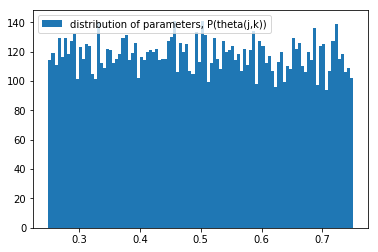

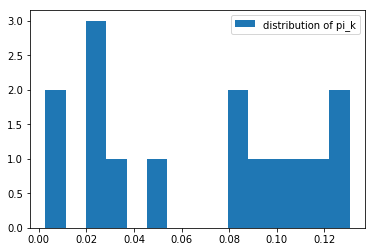

('average of log-likelihoods (of predictions)', -0.20681349258019574)
('average of log-likelihoods (of predictions)', -0.05747367118451783)
('average of log-likelihoods (of predictions)', -0.0254512171870873)
('errorRate', 0.46398)
('average of log-likelihoods (of predictions)', -0.018468089253663257)
('errorRate', 0.39502)
('average of log-likelihoods (of predictions)', -0.01619674837592167)
('errorRate', 0.36936)
('average of log-likelihoods (of predictions)', -0.014843241940753926)
('errorRate', 0.363)
('average of log-likelihoods (of predictions)', -0.014032904932462752)
('errorRate', 0.36064)
('average of log-likelihoods (of predictions)', -0.013551975077908271)
('errorRate', 0.35908)
('average of log-likelihoods (of predictions)', -0.013530094354475357)
('errorRate', 0.35744)
('average of log-likelihoods (of predictions)', -0.01290787921576525)
('errorRate', 0.35602)
('average of log-likelihoods (of predictions)', -0.013018183742598064)
('errorRate', 0.3507)
('average of log-like

In [71]:
MaxIt=20
K=15
affectations, theta, classFrequencies = AlgoEM(dataset, K, MaxIt, subSampledLabels)

## now it is easy to play with parameters ##

In [77]:
classFrequencies

array([0.0730267 , 0.07243827, 0.0776892 , 0.05195905, 0.07531056,
       0.04979178, 0.08094386, 0.08794887, 0.0686359 , 0.08867436,
       0.04727219, 0.05960782, 0.07687281, 0.04632884, 0.04349979])

('this cluster is associated to class :', 4)


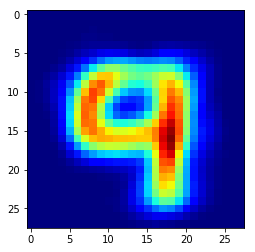

('this cluster is associated to class :', 3)


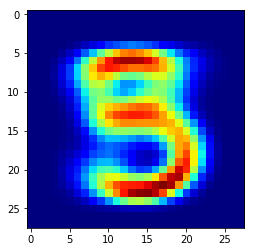

('this cluster is associated to class :', 3)


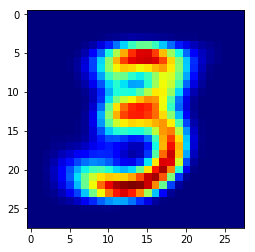

('this cluster is associated to class :', 2)


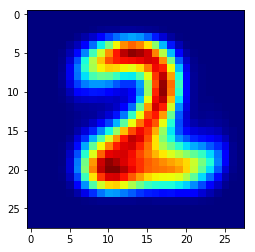

('this cluster is associated to class :', 5)


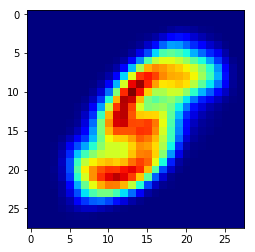

('this cluster is associated to class :', 1)


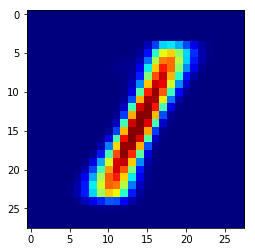

('this cluster is associated to class :', 8)


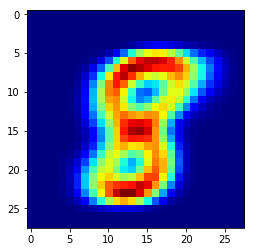

('this cluster is associated to class :', 6)


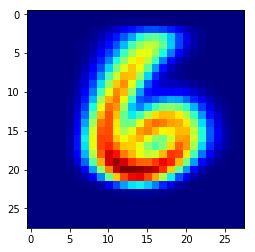

('this cluster is associated to class :', 1)


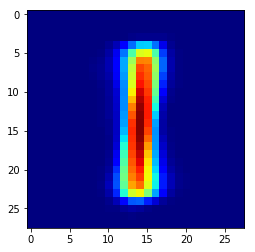

('this cluster is associated to class :', 9)


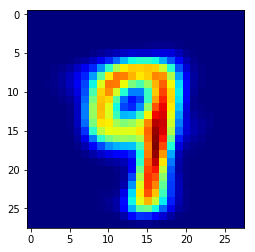

('this cluster is associated to class :', 0)


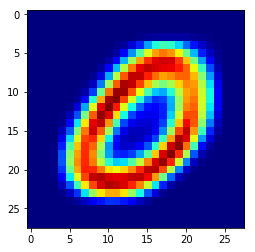

('this cluster is associated to class :', 7)


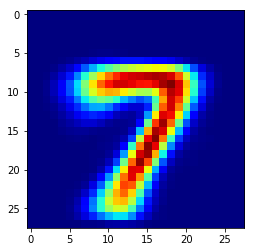

('this cluster is associated to class :', 9)


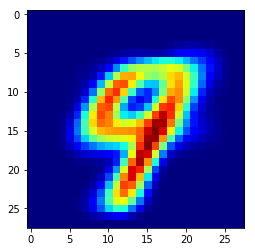

('this cluster is associated to class :', 0)


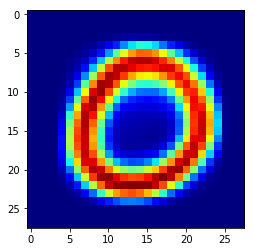

('this cluster is associated to class :', 2)


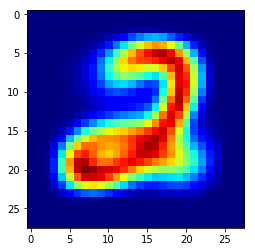

In [80]:
## we can visualize the parameters theta, cluster by cluster
for k in range(K):
    print("this cluster is associated to class :", predictedClass[k])
    plt.imshow(theta[k].reshape(28,28) , matplotlib.pyplot.cm.jet)
    matplotlib.pyplot.show()

In [79]:
predictedClass

array([4, 3, 3, 2, 5, 1, 8, 6, 1, 9, 0, 7, 9, 0, 2])